In [1]:
import pandas as pd
import numpy as np
np.seterr(all="raise")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
df = pd.read_parquet("out/2019-10-02-2d-train.parquet")
print(len(df))

df["h_nelement"] = df["h.shape[0]"] * df["h.shape[1]"]
df["x_nelement"] = df["x.shape[0]"] * df["x.shape[1]"]
df["log10(fft_time/direct_time)"] = np.log10(df.fft_time / df.direct_time)
df["fft_time/direct_time"] = df.fft_time / df.direct_time
df.tail()

5500


,fft_time,direct_time,mode,x.shape[0],x.shape[1],h.shape[0],h.shape[1],random_state,h_nelement,x_nelement,log10(fft_time/direct_time),fft_time/direct_time
5495,0.000683,0.005574,valid,78,85,3,47,5495,141,6630,-0.911525,0.122596
5496,0.000532,0.001234,same,85,5,47,5,5496,235,425,-0.364903,0.431616
5497,0.000685,0.158751,full,85,57,53,25,5497,1325,4845,-2.364915,0.004316
5498,0.000801,0.075002,valid,85,152,16,53,5498,848,12920,-1.971585,0.010676
5499,0.000770,0.124665,same,85,103,53,22,5499,1166,8755,-2.209263,0.006176


In [3]:
df.fft_time.max()

0.010415014500267716

In [4]:
df.direct_time.max()

11.648938894499224

# Visualize ratio

Text(0.5, 1, 'valid')

Text(0.5, 1, 'same')

Text(0.5, 1, 'full')

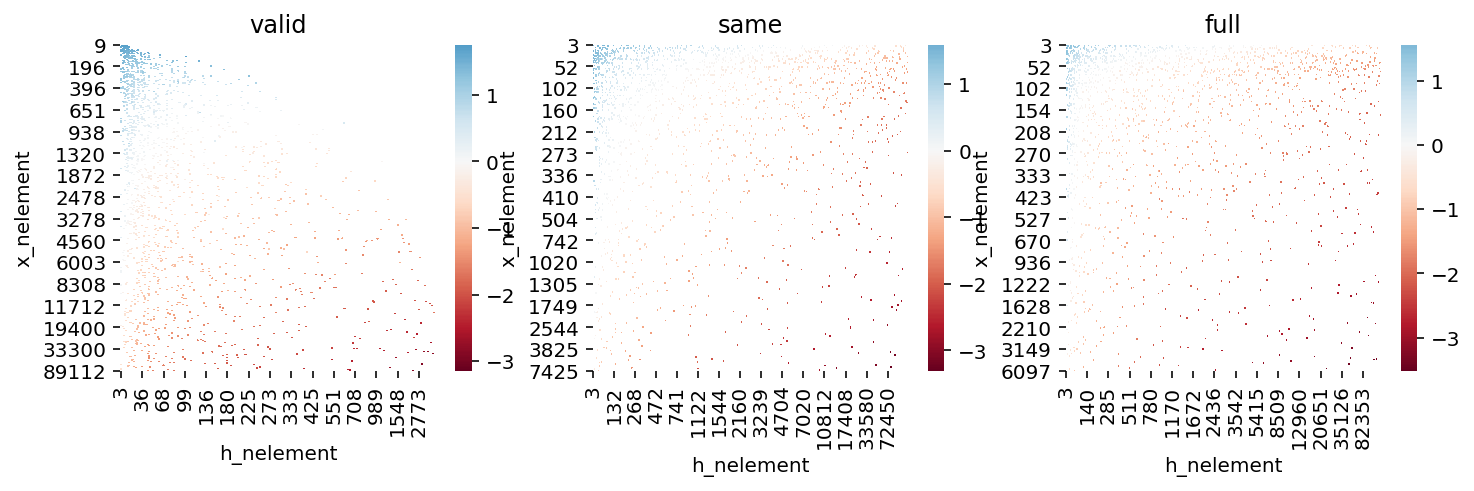

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

w = 3
fig, axs = plt.subplots(ncols=3, figsize=(4 * w, w))
for ax, mode in zip(axs, ["valid", "same", "full"]):
    idx = df["mode"] == mode
    if not idx.sum():
        continue
    show = df[df["mode"] == mode].pivot_table(
        index="x_nelement",
        columns="h_nelement",
        values="log10(fft_time/direct_time)",
    )
    ax = sns.heatmap(
        show,
        center=0,
        ax=ax,
        cmap="RdBu",
    )
    ax.set_title(mode)

# Find big-O constant

``` python
fft, direct = times(O_fft, O_direct)
method = "fft" if fft * O_fft < direct * O_direct else "direct"
```

Use torch to code custom loss function.


In [6]:
from scipy.optimize import curve_fit
from toolz import partial
sum_builtin = sum

def _prod(iterable):
    """
    Product of a list of numbers.
    Faster than np.prod for short lists like array shapes.
    """
    product = 1
    for x in iterable:
        product *= x
    return product

def _fftconv_faster(x_shape, x_size, h_shape, h_size, mode):
    """
    See if using fftconvolve or convolve is faster. The value returned (a
    boolean) depends on the sizes and shapes of the input values.
    The big O ratios were found to hold to different machines, which makes
    sense as it's the ratio that matters (the effective speed of the computer
    is found in both big O constants). Regardless, this had been tuned on an
    early 2015 MacBook Pro with 8GB RAM and an Intel i5 processor.
    """
    if mode == 'full':
        out_shape = [n + k - 1 for n, k in zip(x_shape, h_shape)]
    elif mode == 'same':
        out_shape = x_shape
    elif mode == 'valid':
        out_shape = [n - k + 1 for n, k in zip(x_shape, h_shape)]
    else:
        raise ValueError('mode is invalid')
    out_shape = [o if o > 0 else -o + 2 for o in out_shape]

    # see whether the Fourier transform convolution method or the direct
    # convolution method is faster (discussed in scikit-image PR #1792)
    direct_time = (x_size * h_size * _prod(out_shape))
    fft_time = sum_builtin(n * np.log(n) for n in (x_shape + h_shape +
                                               tuple(out_shape)))
    return fft_time, direct_time
    
def log_time(shapes, O, mode):
# def _fftconv_faster(shapes, O, mode):
    """
    See if using fftconvolve or convolve is faster. The value returned (a
    boolean) depends on the sizes and shapes of the input values.
    The big O ratios were found to hold to different machines, which makes
    sense as it's the ratio that matters (the effective speed of the computer
    is found in both big O constants). Regardless, this had been tuned on an
    early 2015 MacBook Pro with 8GB RAM and an Intel i5 processor.
    """
    times = []
    for shape in shapes:
        x_shape = shape[:2]
        h_shape = shape[2:]
        assert len(shape) == 4
        assert len(x_shape) == len(h_shape) == 2
        fft_time, direct_time = _fftconv_faster(
            x_shape, _prod(x_shape), h_shape, _prod(h_shape), mode,
        )
        times.append([fft_time, direct_time])
    times = np.asarray(times)
    fft_time = times[:, 0]
    direct_time = times[:, 1]
    diff = O * fft_time / direct_time
    
    power = np.log10(abs(diff))
    sign = np.sign(diff)
    return sign * power

def get_constant(df, mode):
    """
    Inputs
    ------
    df : DataFrame with columns x.shape[0], x.shape[1], h.shape[0], h.shape[1] and log10(fft_time/direct_time)
    
    Returns
    -------
    popt : float
        The constant such that constant * fft_time < direct_time
    pstd : float
        The (estimated) standard deviation of popt
    """
    shapes = df[["x.shape[0]", "x.shape[1]", "h.shape[0]", "h.shape[0]"]].values
    times = df["log10(fft_time/direct_time)"].values
    log_time_w_mode = partial(log_time, mode=mode)

#     p0s = {"full": 9e3, "same": 34e3, "valid": 66e3}
#     kwargs = {"p0": 2 * p0s[mode]}
#     kwargs = {"p0": 10e3}
    kwargs = {}
    popt, pcov = curve_fit(log_time_w_mode, shapes, times, **kwargs)
    O = popt.item()
    times_hat = log_time_w_mode(shapes, O)
    return O, np.sqrt(pcov).item(), (times_hat, times)

In [7]:
bigOs = {}
for mode in ["same", "valid", "full"]:
    idx = df["mode"] == mode
    if not idx.sum():
        continue
    fit = df[idx].copy()
    O, std, times = get_constant(fit, mode)
    y_hat, y = times
    fit["predicted_ratio"] = y_hat
    print(mode, O, std)
    bigOs[mode] = {"constant": O, "std": std}


same 23743.55575586141 869.1907838541028
valid 47251.5991118315 1479.9481362774916
full 320494.2385316783 15472.133739696837


In [8]:
constants = pd.DataFrame(bigOs).T
constants["ndim"] = 2

In [9]:
constants.index.name = "mode"
constants

,constant,std,ndim
mode,,,
same,23743.555756,869.190784,2
valid,47251.599112,1479.948136,2
full,320494.238532,15472.133740,2


In [10]:
constants["std"] / constants["constant"]

mode
same     0.036607
valid    0.031321
full     0.048276
dtype: float64

In [11]:
constants.to_csv("constants.csv")